In [1]:
# We are going to create a classifier using the "moons" dataset.
# The goal is to ensemble multiple classifiers to improve prediction accuracy.

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

# Generate a synthetic dataset using make_moons with added noise for complexity
X, y = make_moons(n_samples=1000, noise=0.20, random_state=42)

# Split the dataset into training and testing sets (80% train, 20% test)
# Stratify ensures class distribution is preserved in both sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# Create individual classifier models
log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC()

# Create a voting classifier that combines the individual classifiers
# Voting is set to "hard" (majority voting on predicted class labels)
hard_voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')

# Train the voting classifier (this will fit all included models on the training data)
hard_voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('rf', RandomForestClassifier()), ('svc', SVC())])

In [3]:
# Let's test the results
from sklearn.metrics import accuracy_score

# Train and evaluate each individual classifier and the voting ensemble
for clf in (log_clf, rnd_clf, svm_clf, hard_voting_clf):
    clf.fit(X_train, y_train)  # train the model
    y_pred = clf.predict(X_test)  # make predictions on the test set
    print(f"{clf.__class__.__name__}: Accuracy = {accuracy_score(y_test, y_pred):.4f}")  # print accuracy

LogisticRegression: Accuracy = 0.9100
RandomForestClassifier: Accuracy = 0.9850
SVC: Accuracy = 0.9900
VotingClassifier: Accuracy = 0.9900


In [4]:
# Let's test the "soft voting" configuration
# Since this is not the default for SVC, we need to set probability=True to enable predicted probabilities
soft_svm_clf = SVC(probability=True)

# We set up the soft voting classifier using all defined models
soft_voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', soft_svm_clf)],
    voting='soft')

# Train the soft voting ensemble (this also trains all included models internally)
soft_voting_clf.fit(X_train, y_train)

# We loop through each model and evaluate its accuracy on the test set
for clf in (log_clf, rnd_clf, soft_svm_clf, soft_voting_clf):
    clf.fit(X_train, y_train)  # train individual model
    y_pred = clf.predict(X_test)  # predict on test set
    print(f"{clf.__class__.__name__}: Accuracy = {accuracy_score(y_test, y_pred):.4f}")  # display accuracy

LogisticRegression: Accuracy = 0.9100
RandomForestClassifier: Accuracy = 0.9800
SVC: Accuracy = 0.9900
VotingClassifier: Accuracy = 0.9850


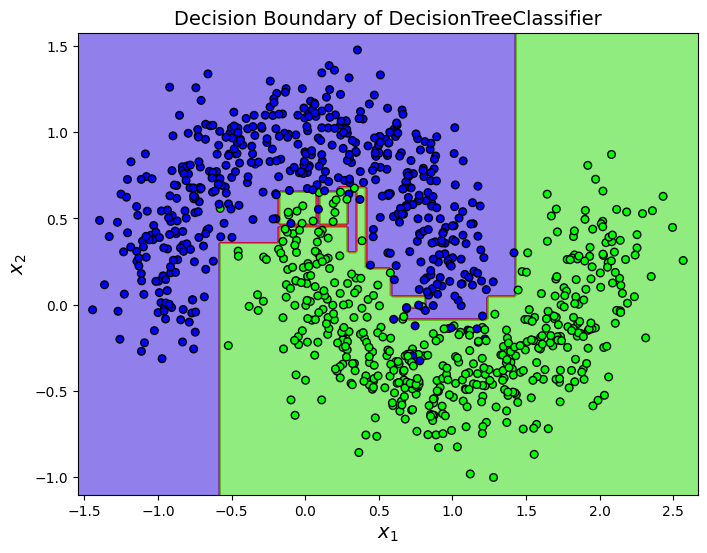

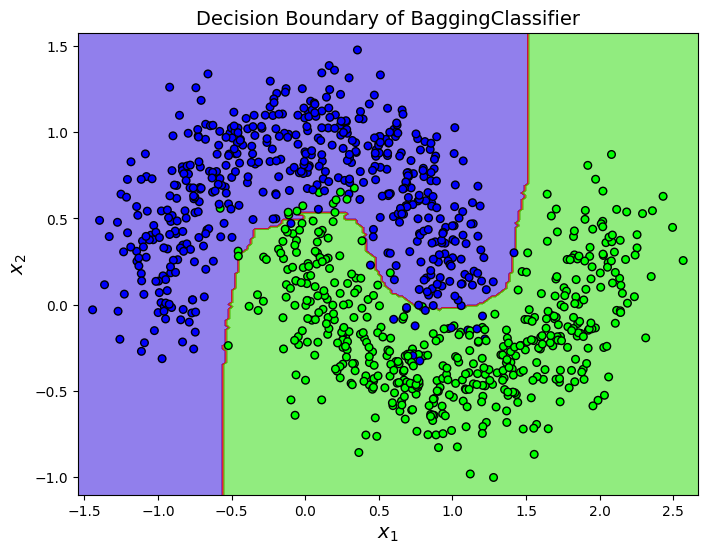

In [5]:
# Let's now train the same classifier using the bagging method
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

# We'll compare a single DecisionTreeClassifier 
# With a BaggingClassifier that uses multiple decision trees

# create a single DecisionTreeClassifier
dt_clf = DecisionTreeClassifier()

# Train the single decision tree
dt_clf.fit(X_train, y_train)

# Configure the BaggingClassifier
# - base estimator: DecisionTreeClassifier
# - n_estimators: 500 decision trees
# - max_samples: each tree trains on 100 instances (with replacement)
# - bootstrap: True (sampling with replacement)
# - n_jobs: -1 (use all available CPU cores)
# - oob_score: True (use out-of-bag samples to estimate generalization accuracy)
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=-1,
    oob_score=True)

# Train the bagging classifier
bag_clf.fit(X_train, y_train)

# Function to plot the decision boundary
def plot_decision_boundary(clf, X, y, alpha=0.5):
    x1s = np.linspace(X[:, 0].min() - 0.1, X[:, 0].max() + 0.1, 200)
    x2s = np.linspace(X[:, 1].min() - 0.1, X[:, 1].max() + 0.1, 200)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    
    plt.contourf(x1, x2, y_pred, alpha=alpha, cmap=plt.cm.brg)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=30, edgecolors='k', cmap=plt.cm.brg)
    plt.xlabel("$x_1$", fontsize=14)
    plt.ylabel("$x_2$", fontsize=14)

# Plot decision boundary for the single decision tree
plt.figure(figsize=(8, 6))
plot_decision_boundary(dt_clf, X, y)
plt.title("Decision Boundary of DecisionTreeClassifier", fontsize=14)
plt.show()

# Plot decision boundary for the bagging classifier
plt.figure(figsize=(8, 6))
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Boundary of BaggingClassifier", fontsize=14)
plt.show()

In [6]:
# Accuracy test using out-of-bag (oob) instances
print(f"OOB Accuracy: {bag_clf.oob_score_:.4f}")

OOB Accuracy: 0.9613


In [7]:
# Predictions on the test set
y_pred = bag_clf.predict(X_test)

# Accuracy on the test set
accuracy_score(y_test, y_pred)

print(f"OOB Accuracy: {bag_clf.oob_score_:.4f}")
print(f"Test Set Accuracy: {accuracy_score(y_test, y_pred):.4f}")

OOB Accuracy: 0.9613
Test Set Accuracy: 0.9850
